In [1]:
import pandas as pd
import cv2
from matplotlib import pyplot as plt

import numpy as np
import os 
import PIL
import PIL.Image
import tensorflow as tf

model = tf.keras.models.load_model("/home/adleywong/train25.h5")

2021-12-09 19:18:19.095584: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-09 19:18:19.205637: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-09 19:18:19.206358: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-09 19:18:19.207524: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [2]:
data = pd.read_csv("/home/adleywong/car_ims.csv")
data.head()

Unnamed: 0            img_path  label        x1        y1        x2  \
0           0  car_ims/000001.jpg      0  0.109375  0.009115  0.833008   
1           1  car_ims/000002.jpg      0  0.104348  0.109589  0.958696   
2           2  car_ims/000003.jpg      0  0.022581  0.017167  0.893548   
3           3  car_ims/000004.jpg      0  0.132000  0.265957  0.788000   
4           4  car_ims/000005.jpg      0  0.058824  0.125000  0.976471   

         y2  
0  0.933594  
1  0.922374  
2  0.772532  
3  0.797872  
4  0.906250

In [3]:
classes = pd.read_csv("/home/adleywong/labels.csv")
classes.head()

Unnamed: 0      0
0           0     AM
1           1  Acura
2           2  Aston
3           3   Audi
4           4    BMW

In [4]:
def predictBBoxScoreFromDataset(index):
    # init with ground truth
    img = cv2.imread("/home/adleywong/" + data.img_path[index])
    
    pred_label, pred_img = predictBBoxScore("/home/adleywong/" + data.img_path[index], img=img)
    
    h, w, _ = img.shape

    left_corner = (int(data.x1[index] * w), int(data.y1[index] * h))
    right_corner = (int(data.x2[index] * w), int(data.y2[index] * h))

    img = cv2.rectangle(pred_img, left_corner, right_corner, (0, 255, 0), 3)
    
    return classes["0"][data.label[index]], pred_label, img

In [5]:
def predictBBoxScore(path="", img=None):
    if img is None:
        img = cv2.imread(path)
        h, w, _ = img.shape
    else:
        h, w, _ = img.shape
        
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # perform CNN prediction
    img_width, img_height = (720, 720)
    input_img = tf.keras.utils.load_img(
        path, target_size=(img_height, img_width)
    )
    img_array = tf.keras.utils.img_to_array(input_img)
    img_array = tf.expand_dims(img_array, 0)

    score, bbox = model.predict(img_array)
    
    # get prediction
    pred_class = classes["0"][np.argmax(score)]

    pred_left_corner = (int(bbox[0][0] * w), int(bbox[0][1] * h))
    pred_right_corner = (int(bbox[0][2] * w), int(bbox[0][3] * h))

    pred_img = cv2.rectangle(img, pred_left_corner, pred_right_corner, (0, 255, 255), 3)
    
    return pred_class, pred_img

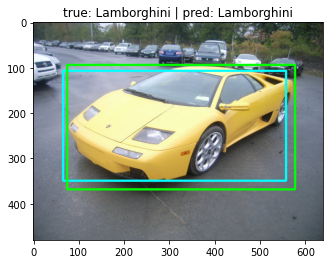

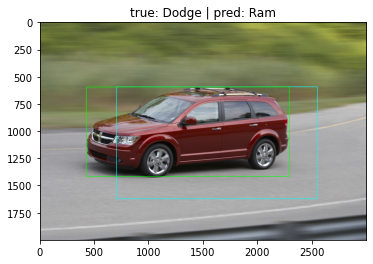

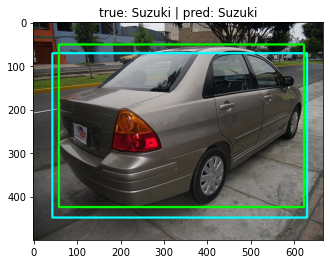

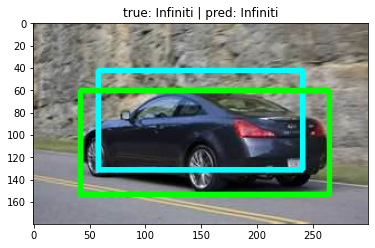

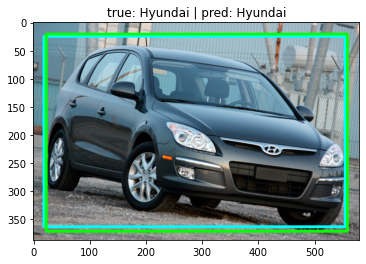

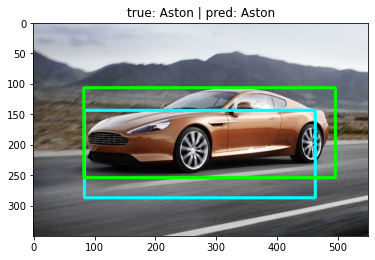

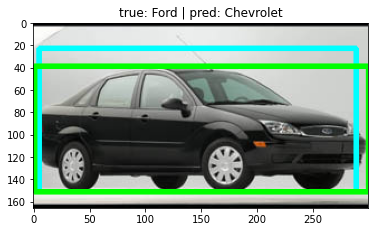

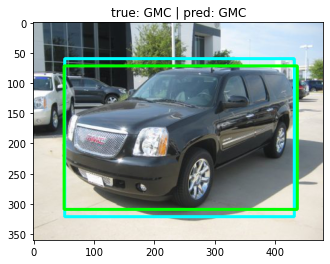

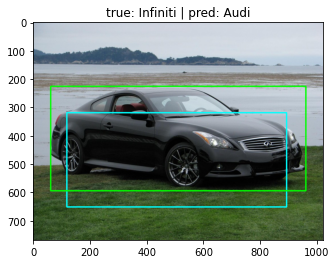

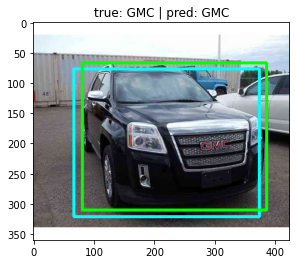

In [14]:
import random

for i in range(10):
    true_label, pred_label, pred = predictBBoxScoreFromDataset(random.randint(0, data.shape[0]))
    plt.imshow(pred)
    plt.title("true: " + true_label + " | pred: " + pred_label)
    plt.show()

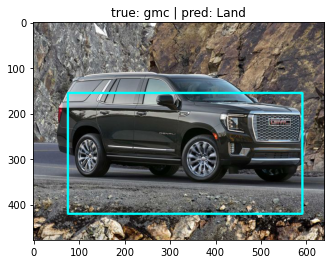

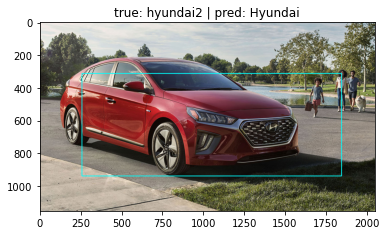

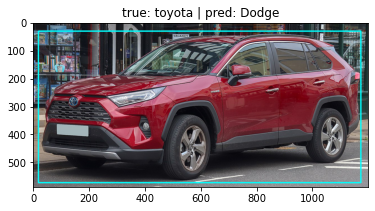

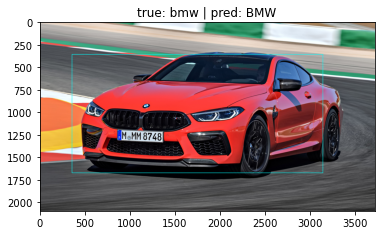

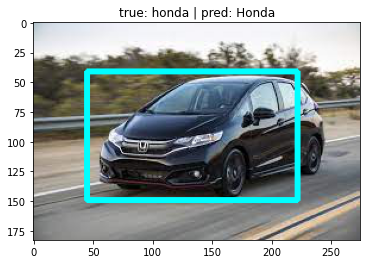

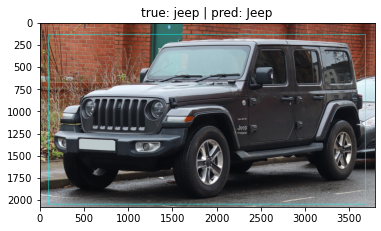

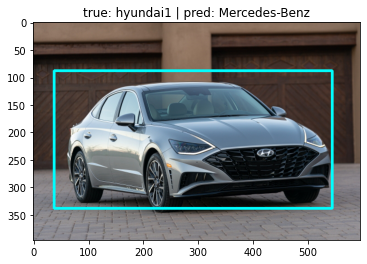

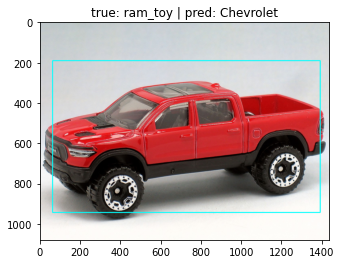

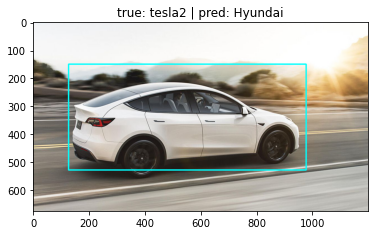

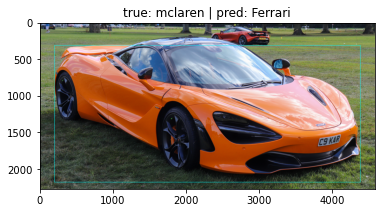

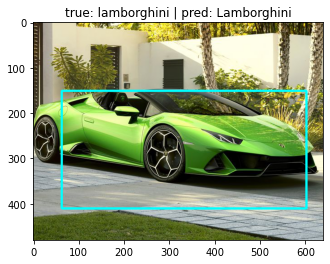

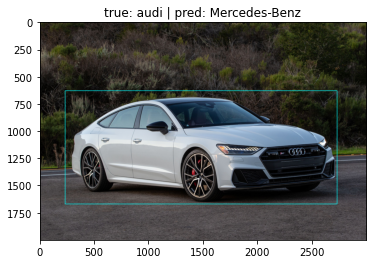

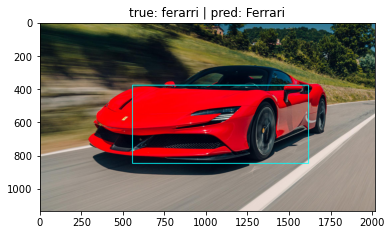

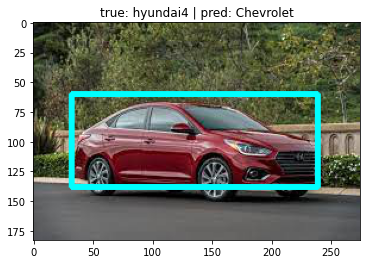

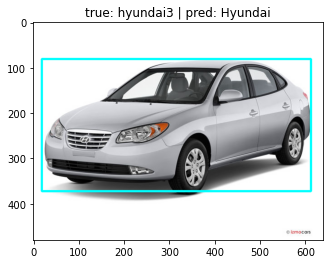

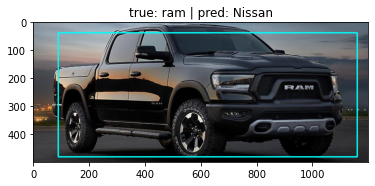

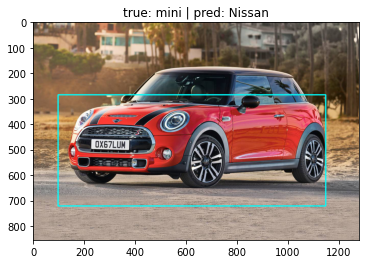

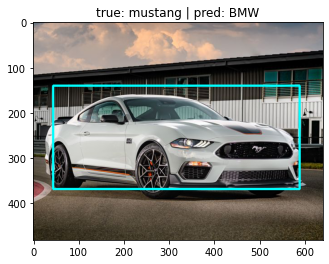

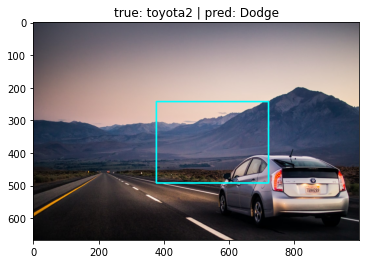

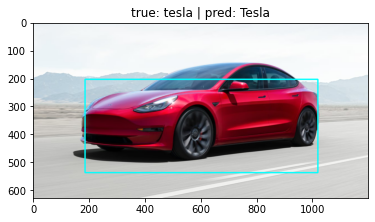

In [7]:
import os

for file_name in os.listdir("./test/images/"):
    if file_name[0] != ".":
        pred_label, pred = predictBBoxScore(f"test/images/{file_name}")
        plt.imshow(pred)
        plt.title("true: " + file_name.split(".")[0] + " | pred: " + pred_label)
        plt.show()

Text(0.5, 1.0, 'true: dog | pred: Ford')

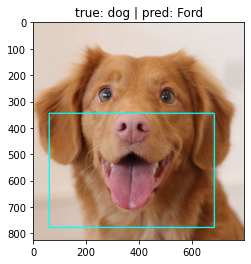

In [12]:
file_name = "dog.jpeg"

pred_label, pred = predictBBoxScore(path=f"./{file_name}")
plt.imshow(pred)
plt.title("true: " + file_name.split(".")[0] + " | pred: " + pred_label)